## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

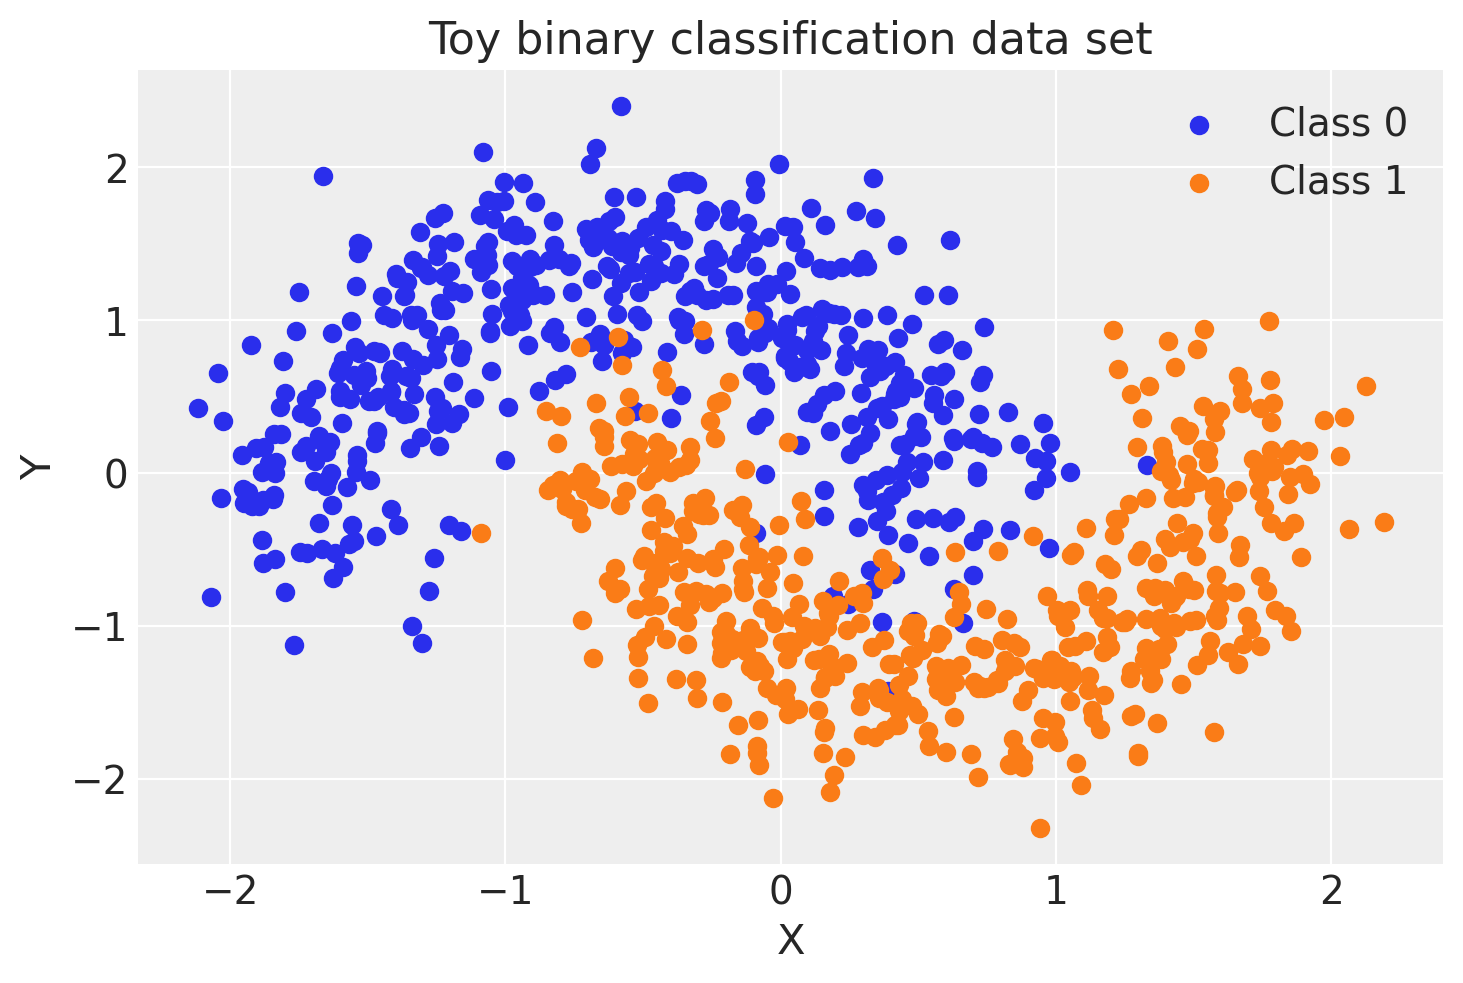

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set");

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)


        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, testval=init_1, dims=("train_cols", "hidden_layer_1")
        )
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, testval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, testval=init_out, dims="hidden_layer_2")

        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

In [6]:
%%time

with neural_network:
    trace = pm.sample(draws=100, cores=1)

C:\Users\mik16\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 92 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


Wall time: 1min 37s


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mik16\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


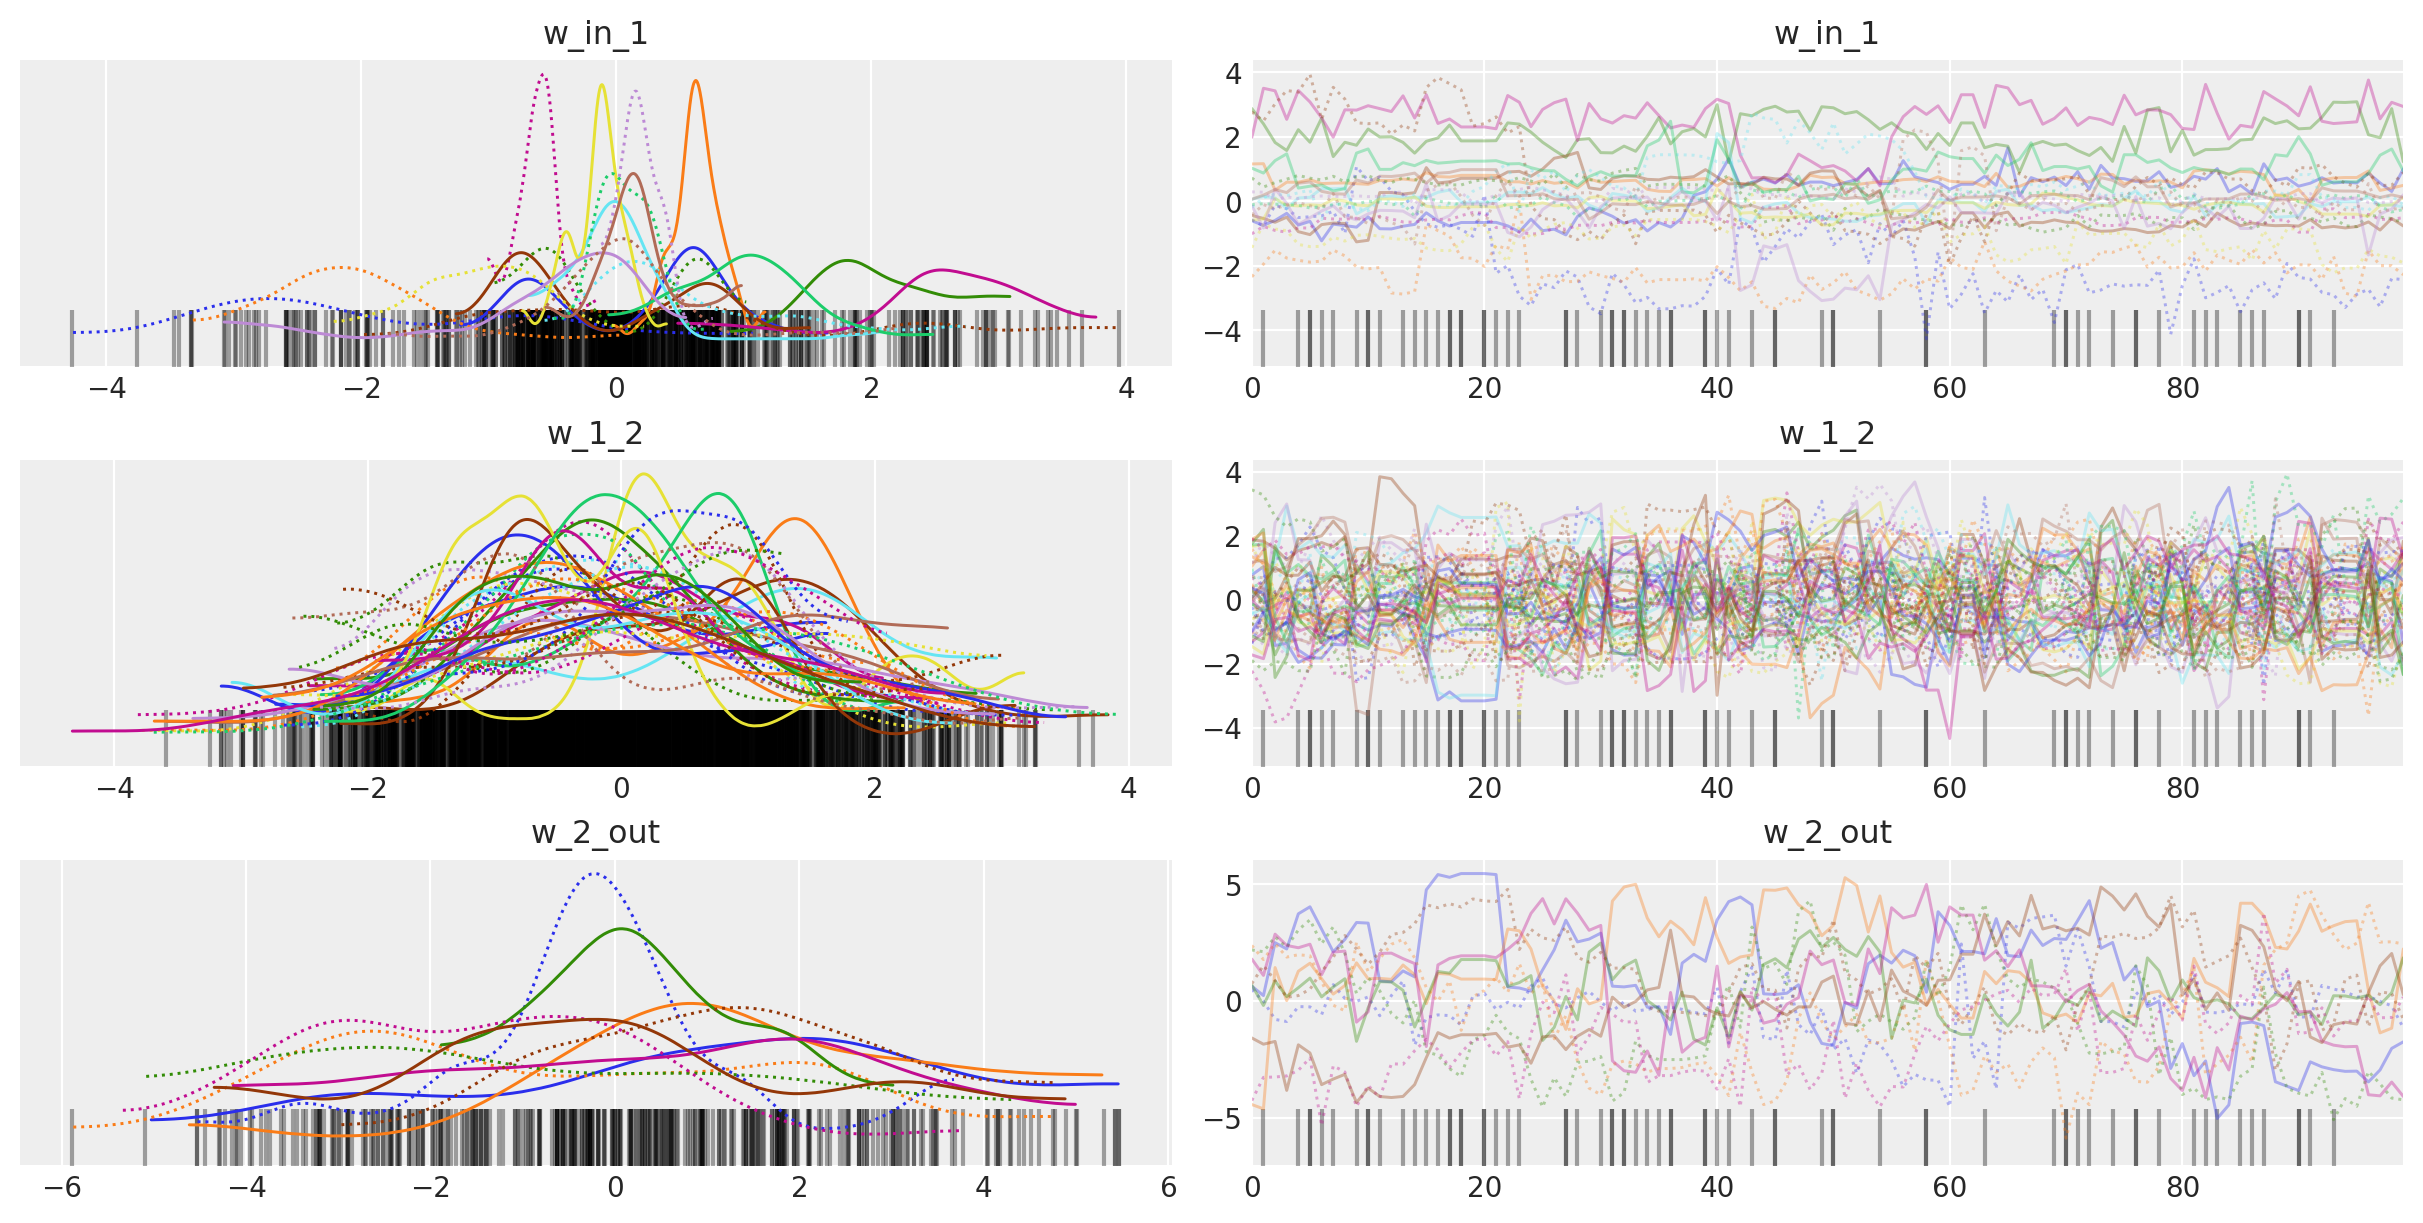

In [7]:
az.plot_trace(trace);

No handles with labels found to put in legend.


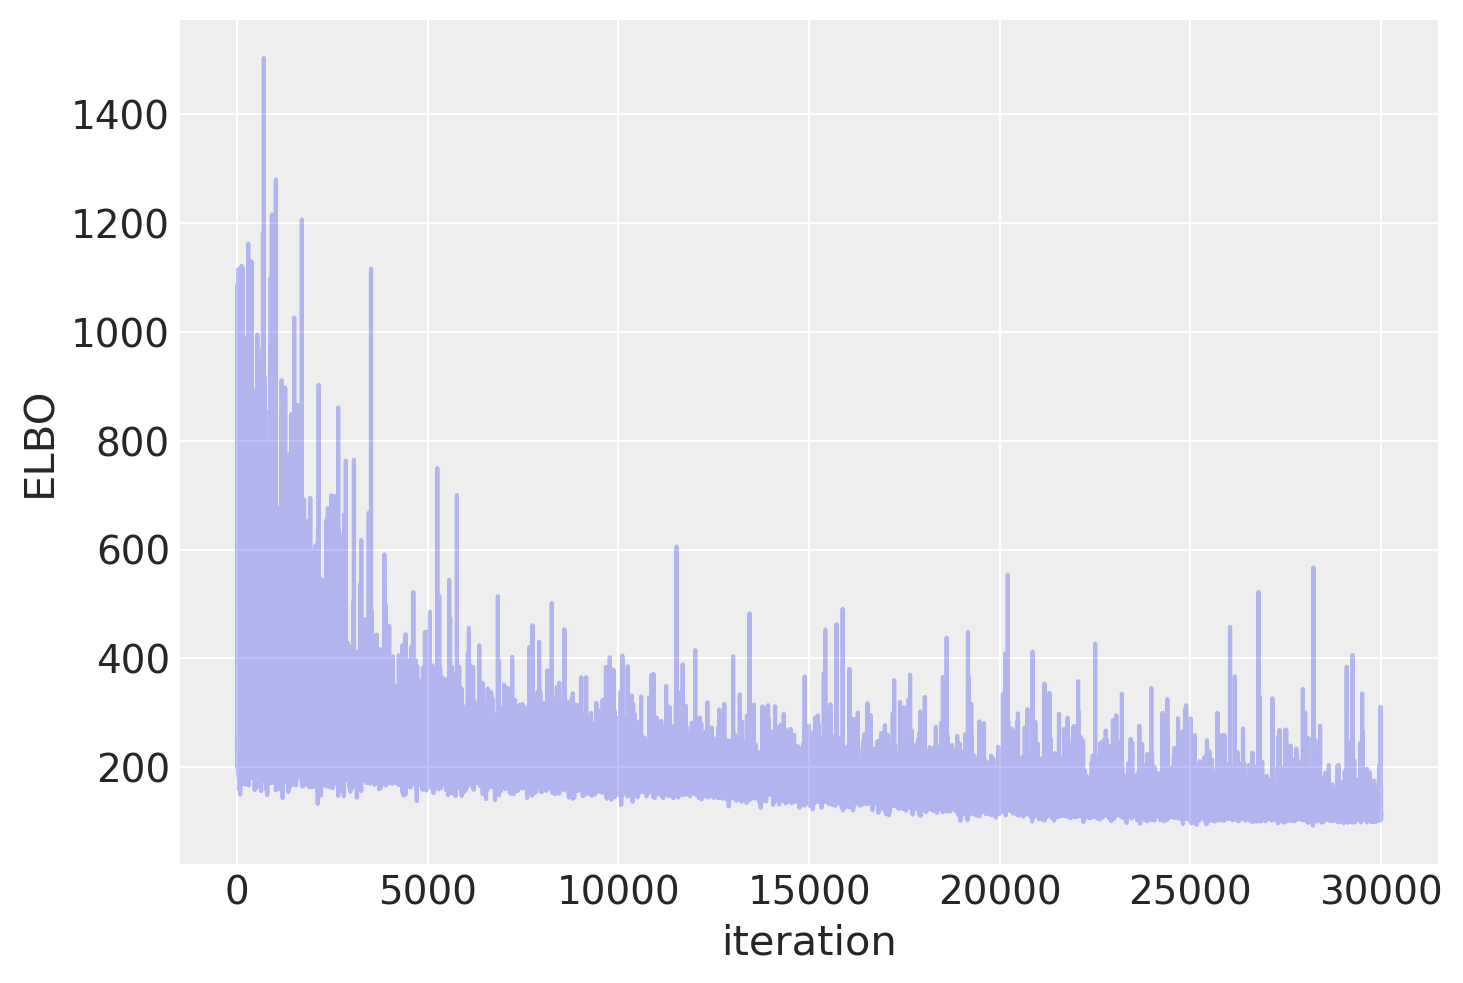

In [17]:
plt.plot(approx.hist, alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [18]:
neural_network.out.distribution.p

sigmoid.0

In [19]:
x = T.matrix("X")
n = T.iscalar("n")
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba)

MissingInputError: Input 4 of the graph (indices start from 0), used to compute for{cpu,scan_fn}(Subtensor{int64}.0, Subtensor{:int64:}.0, Subtensor{int64}.0, X, w_in_1, w_1_2, w_2_out), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [11]:
%%timeit
sample_proba(X_test, 500).mean(0) > 0.5

66.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

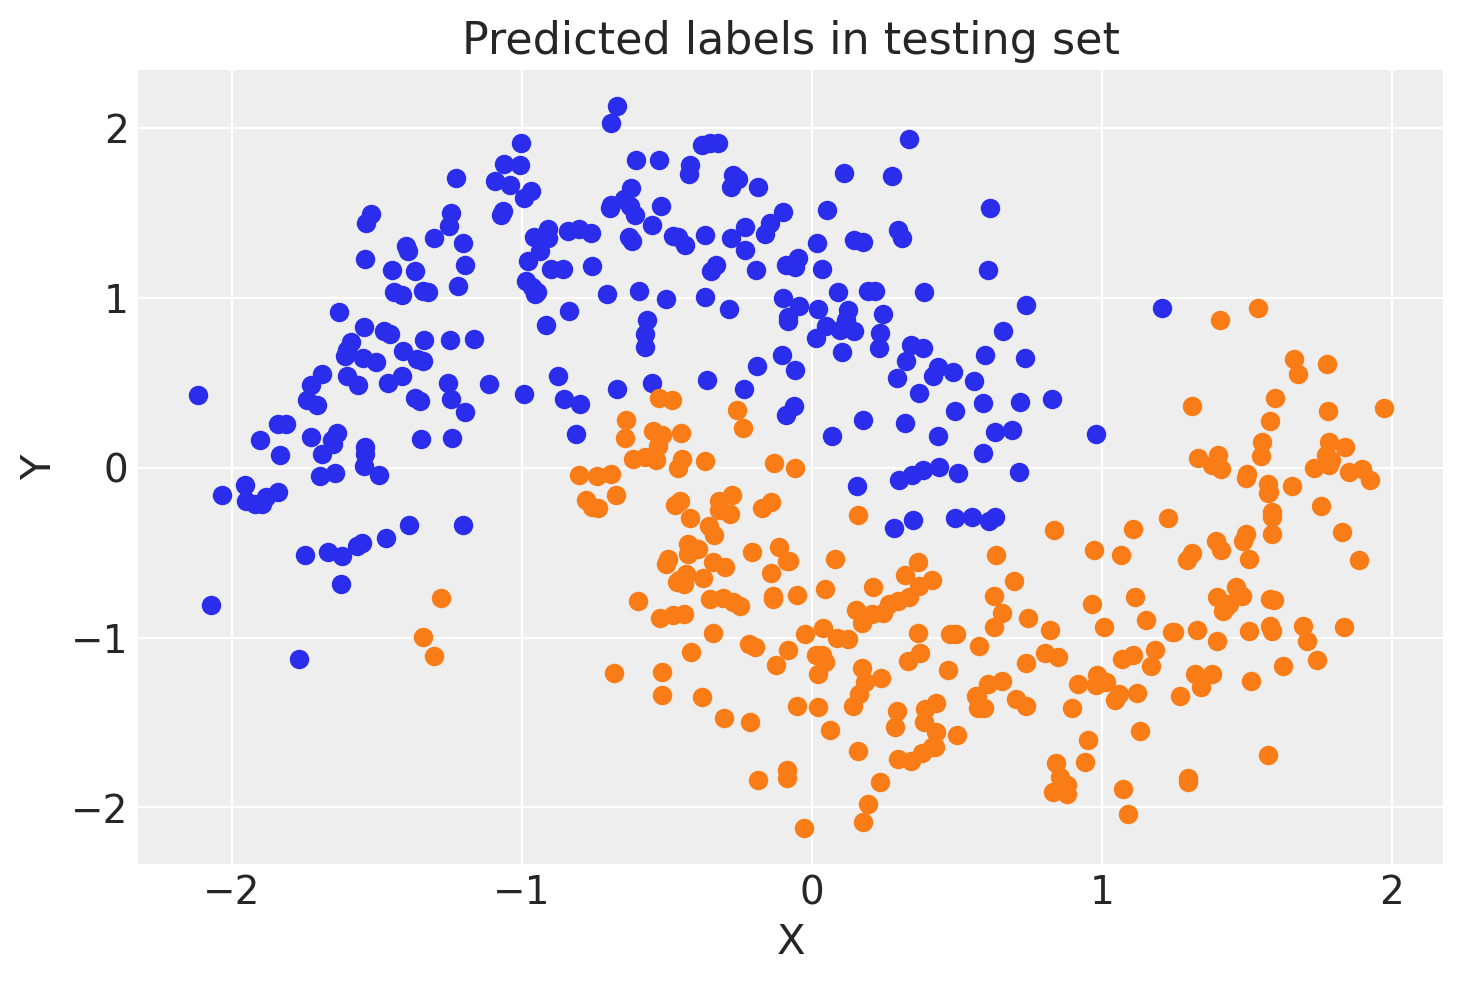

In [13]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [14]:
print("Accuracy = {:.2f}%".format((Y_test == pred).mean() * 100))

Accuracy = 94.40%


In [69]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [70]:
ppc = sample_proba(grid_2d, 500)

### Probability surface

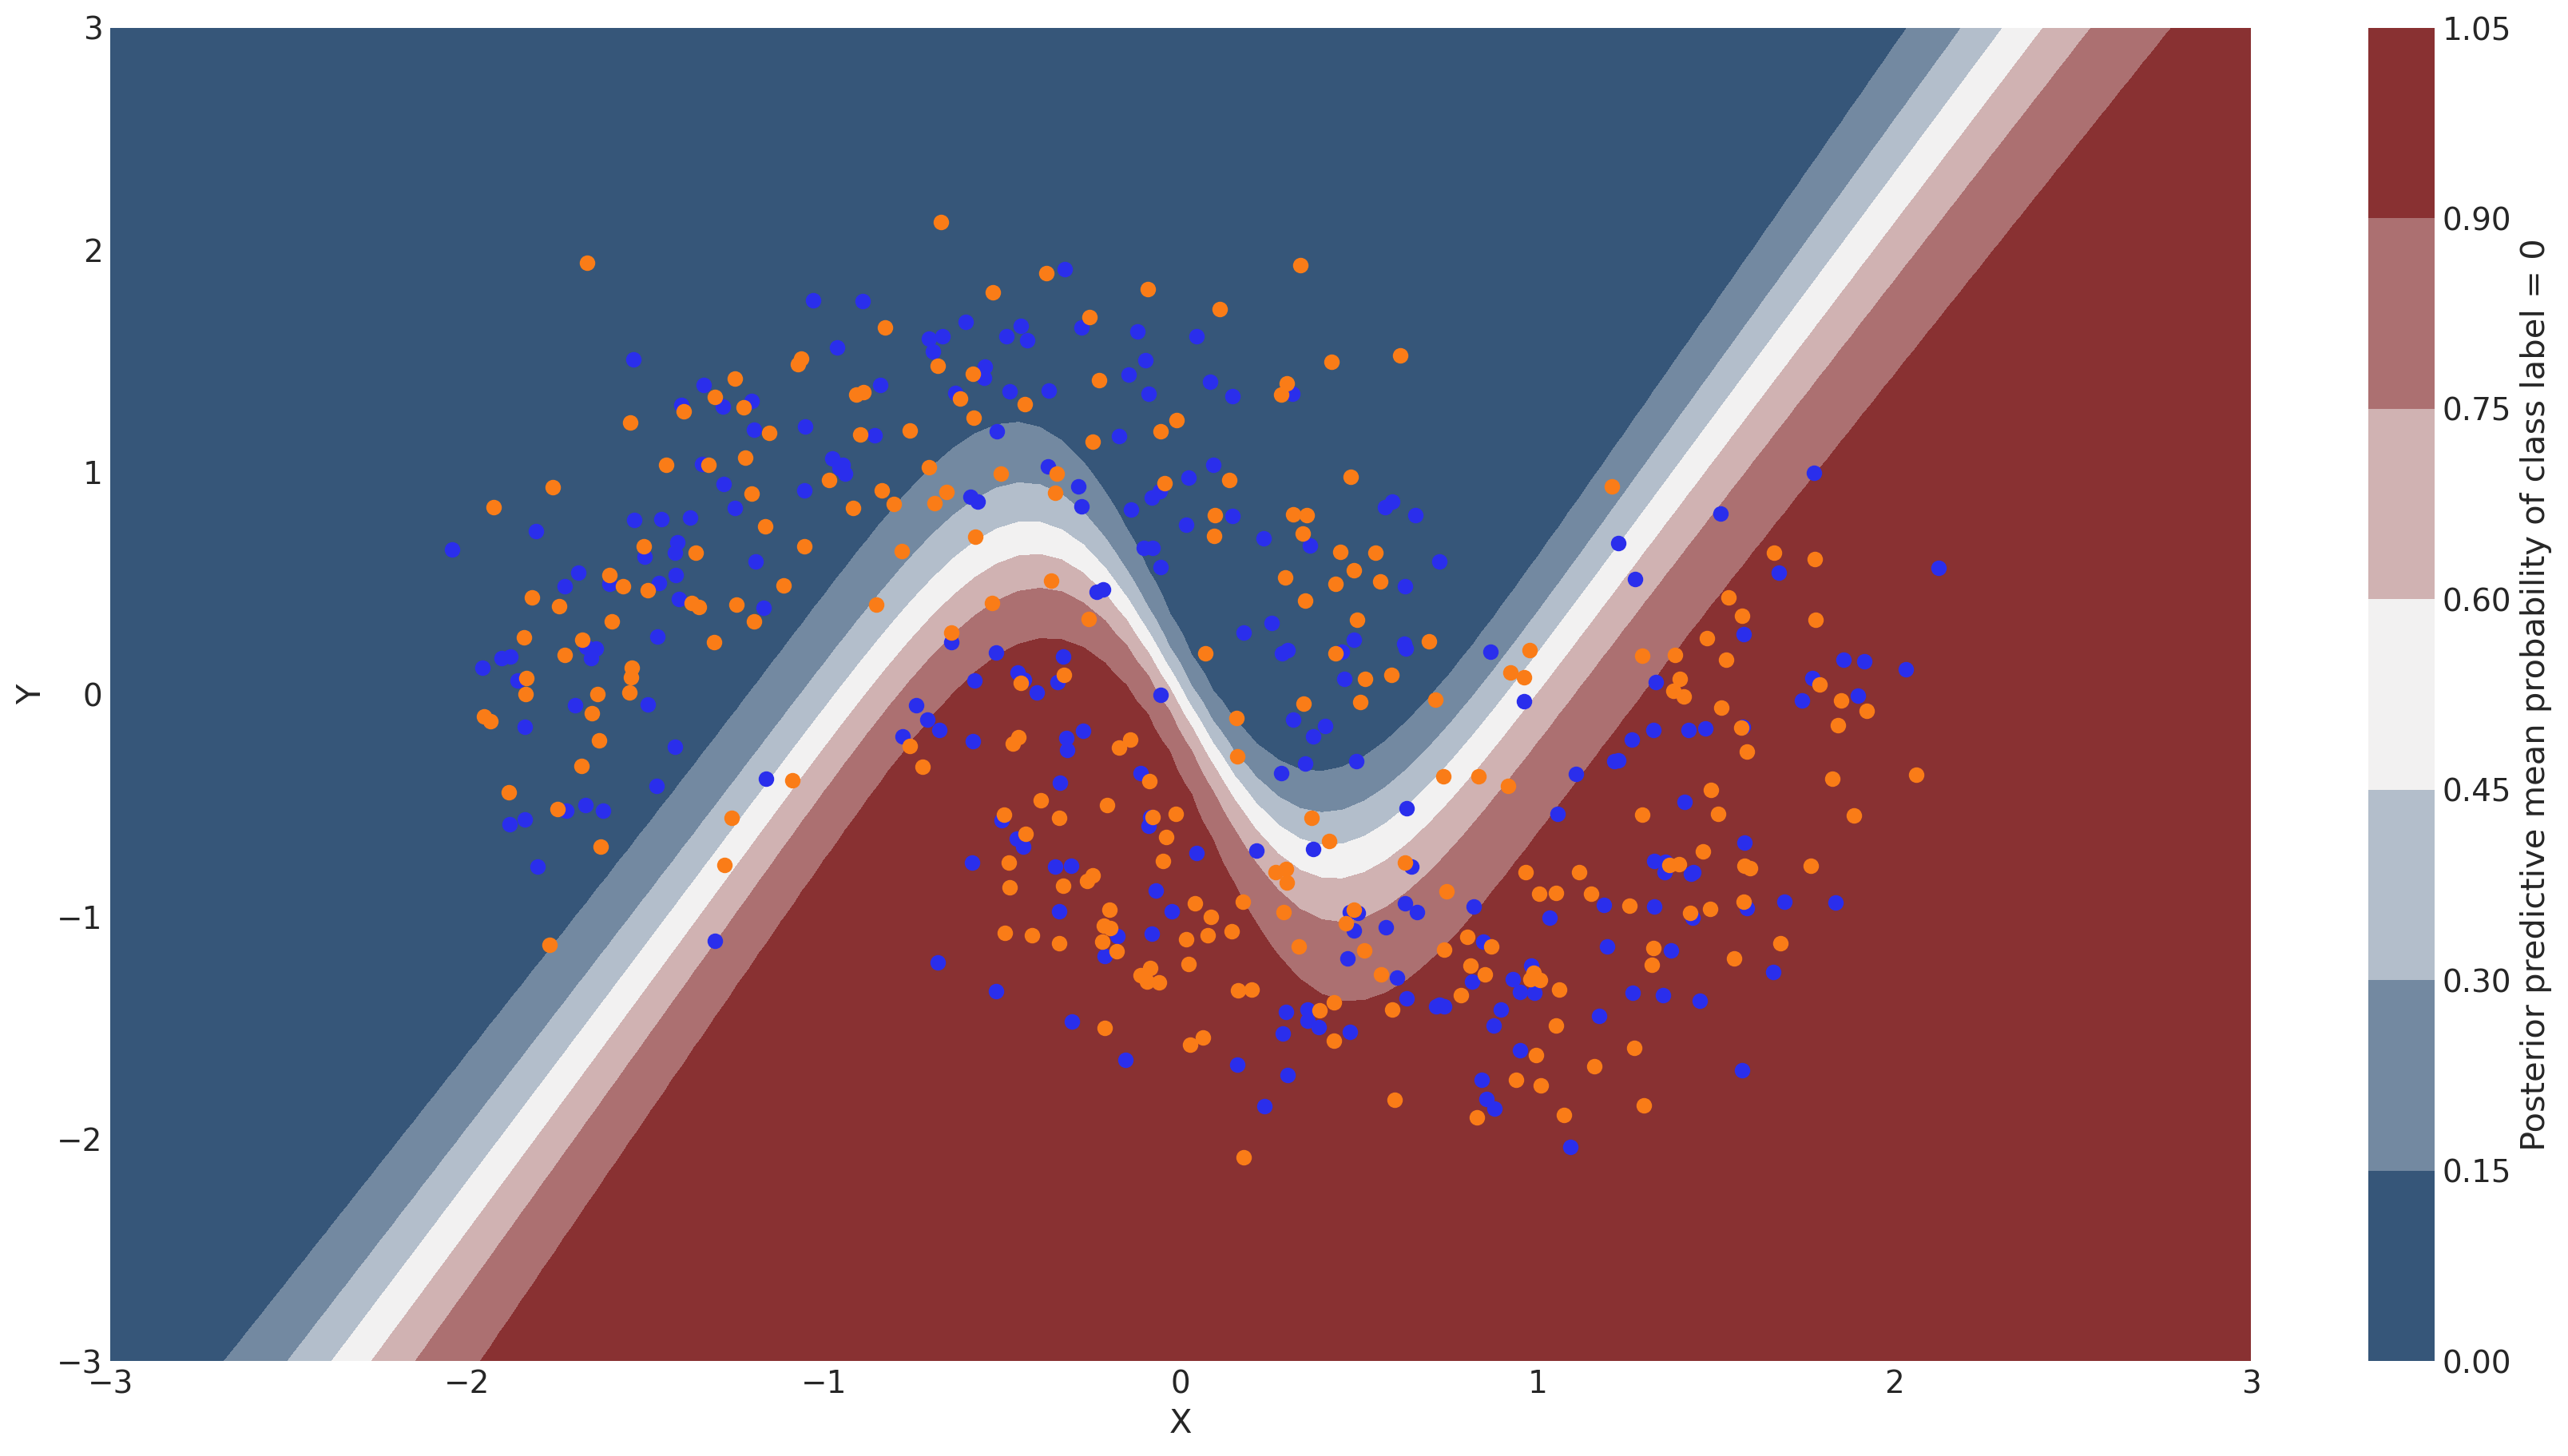

In [71]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");

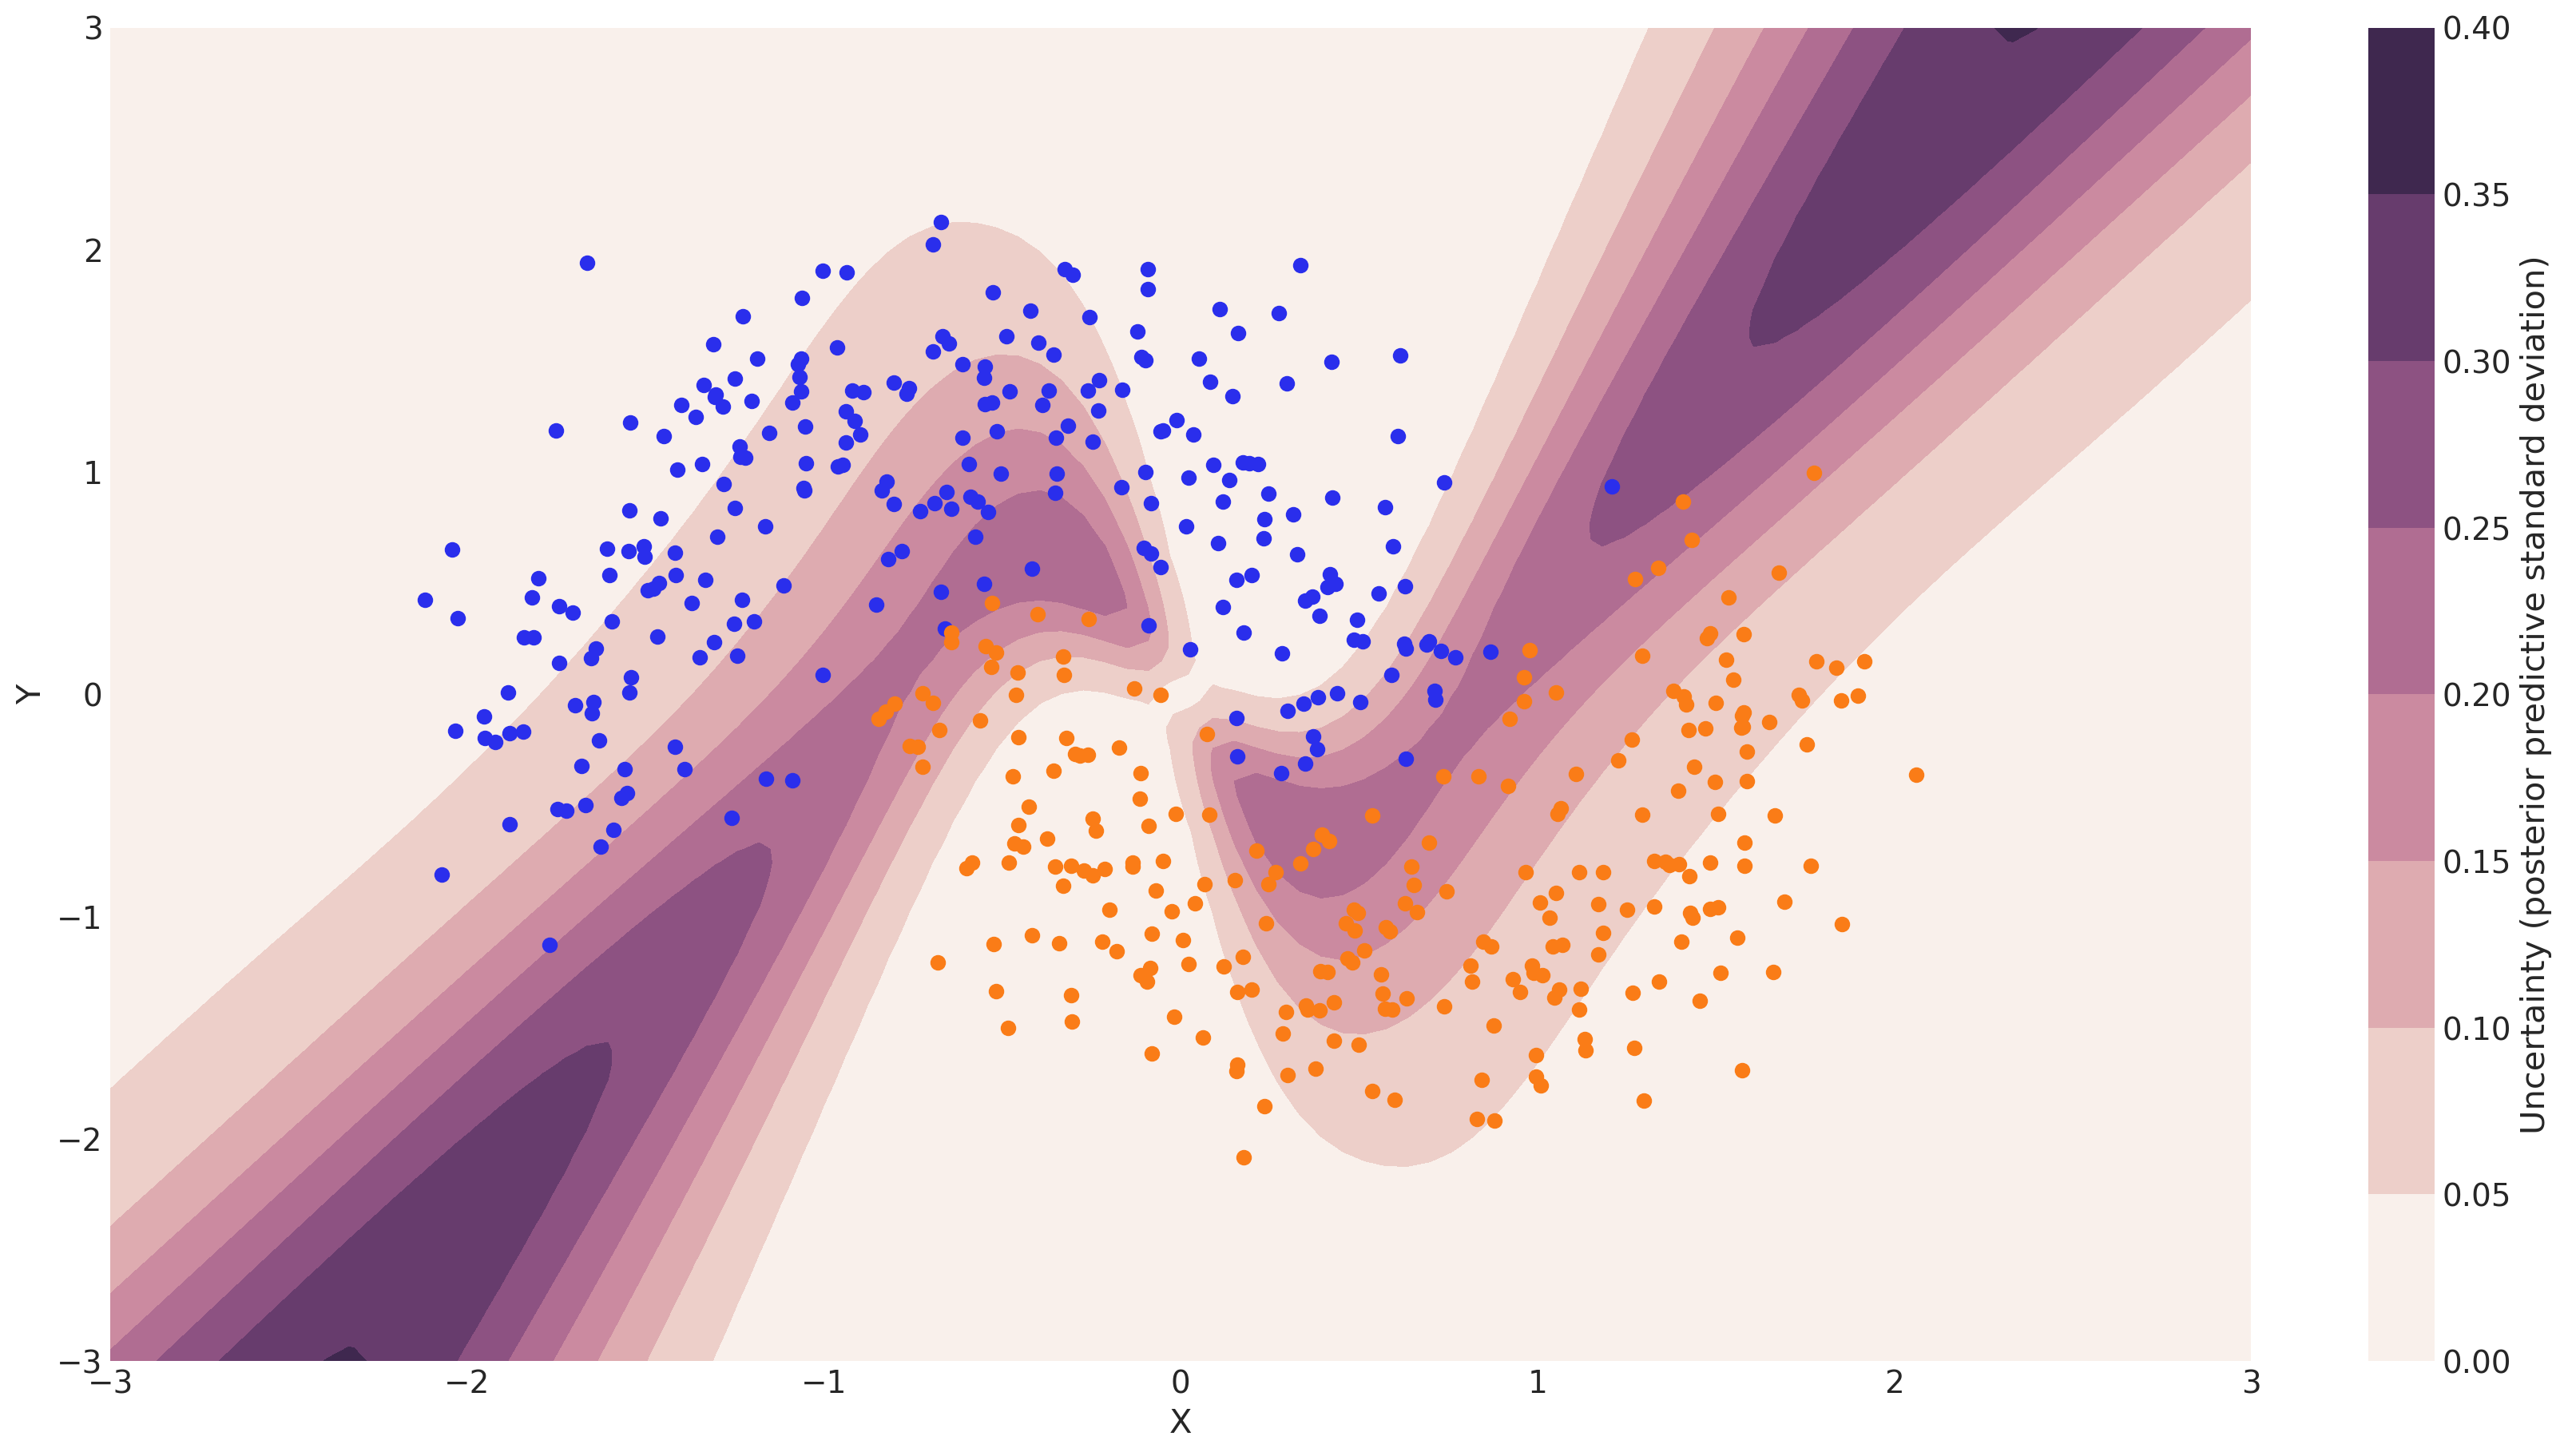

In [37]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");

In [36]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

C:\Users\mik16\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\Users\mik16\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Finished [100%]: Average Loss = 115.35


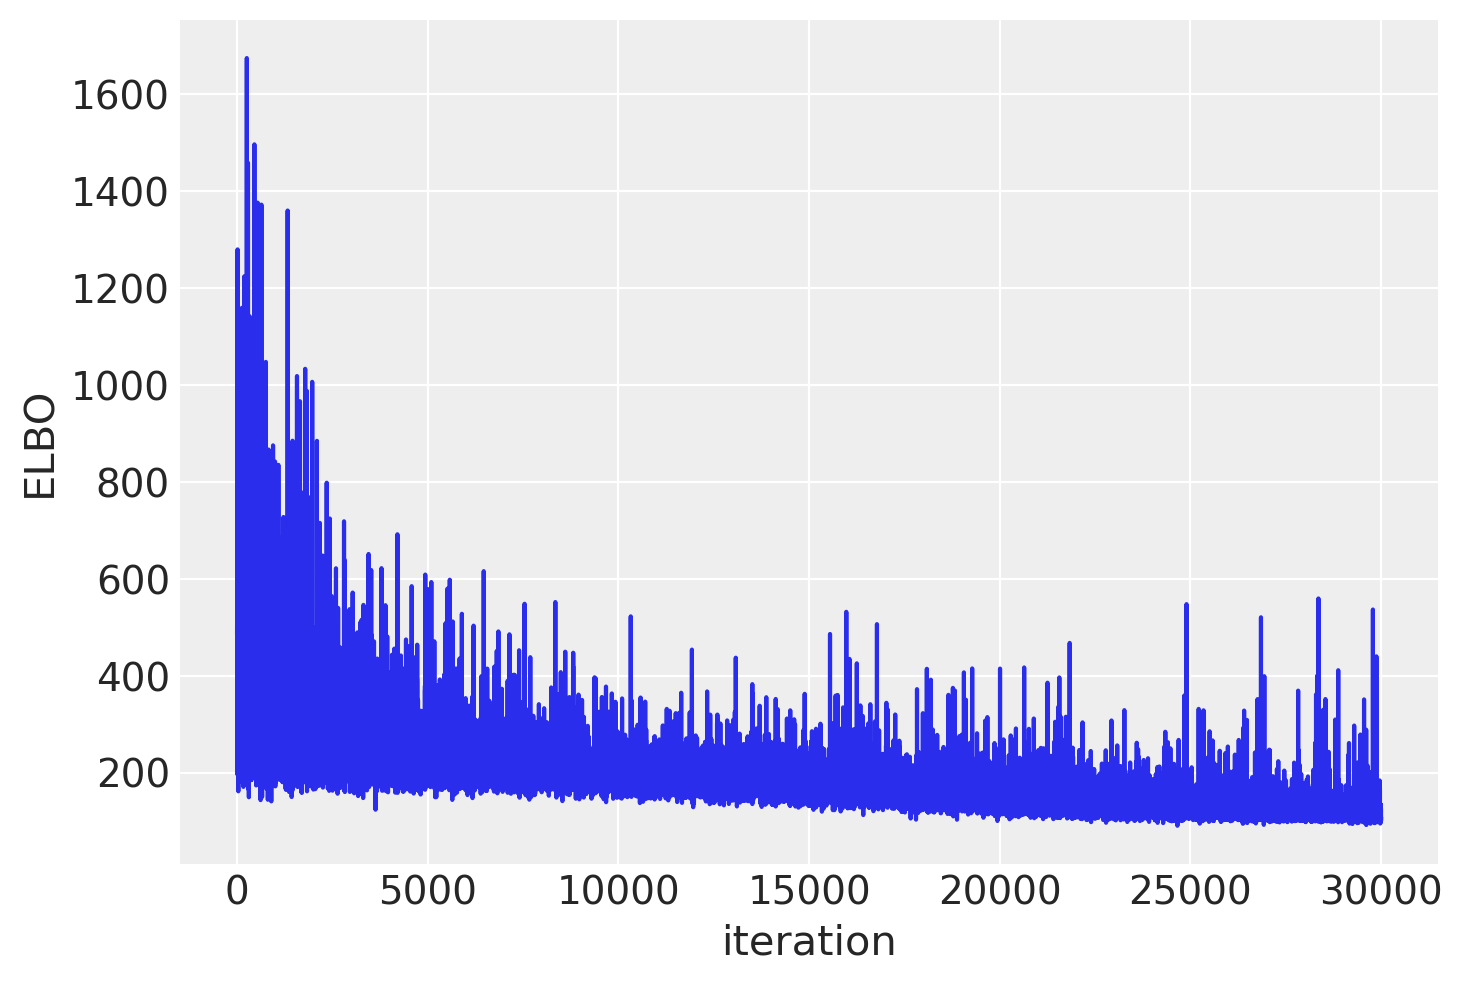

In [38]:
plt.plot(inference.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");

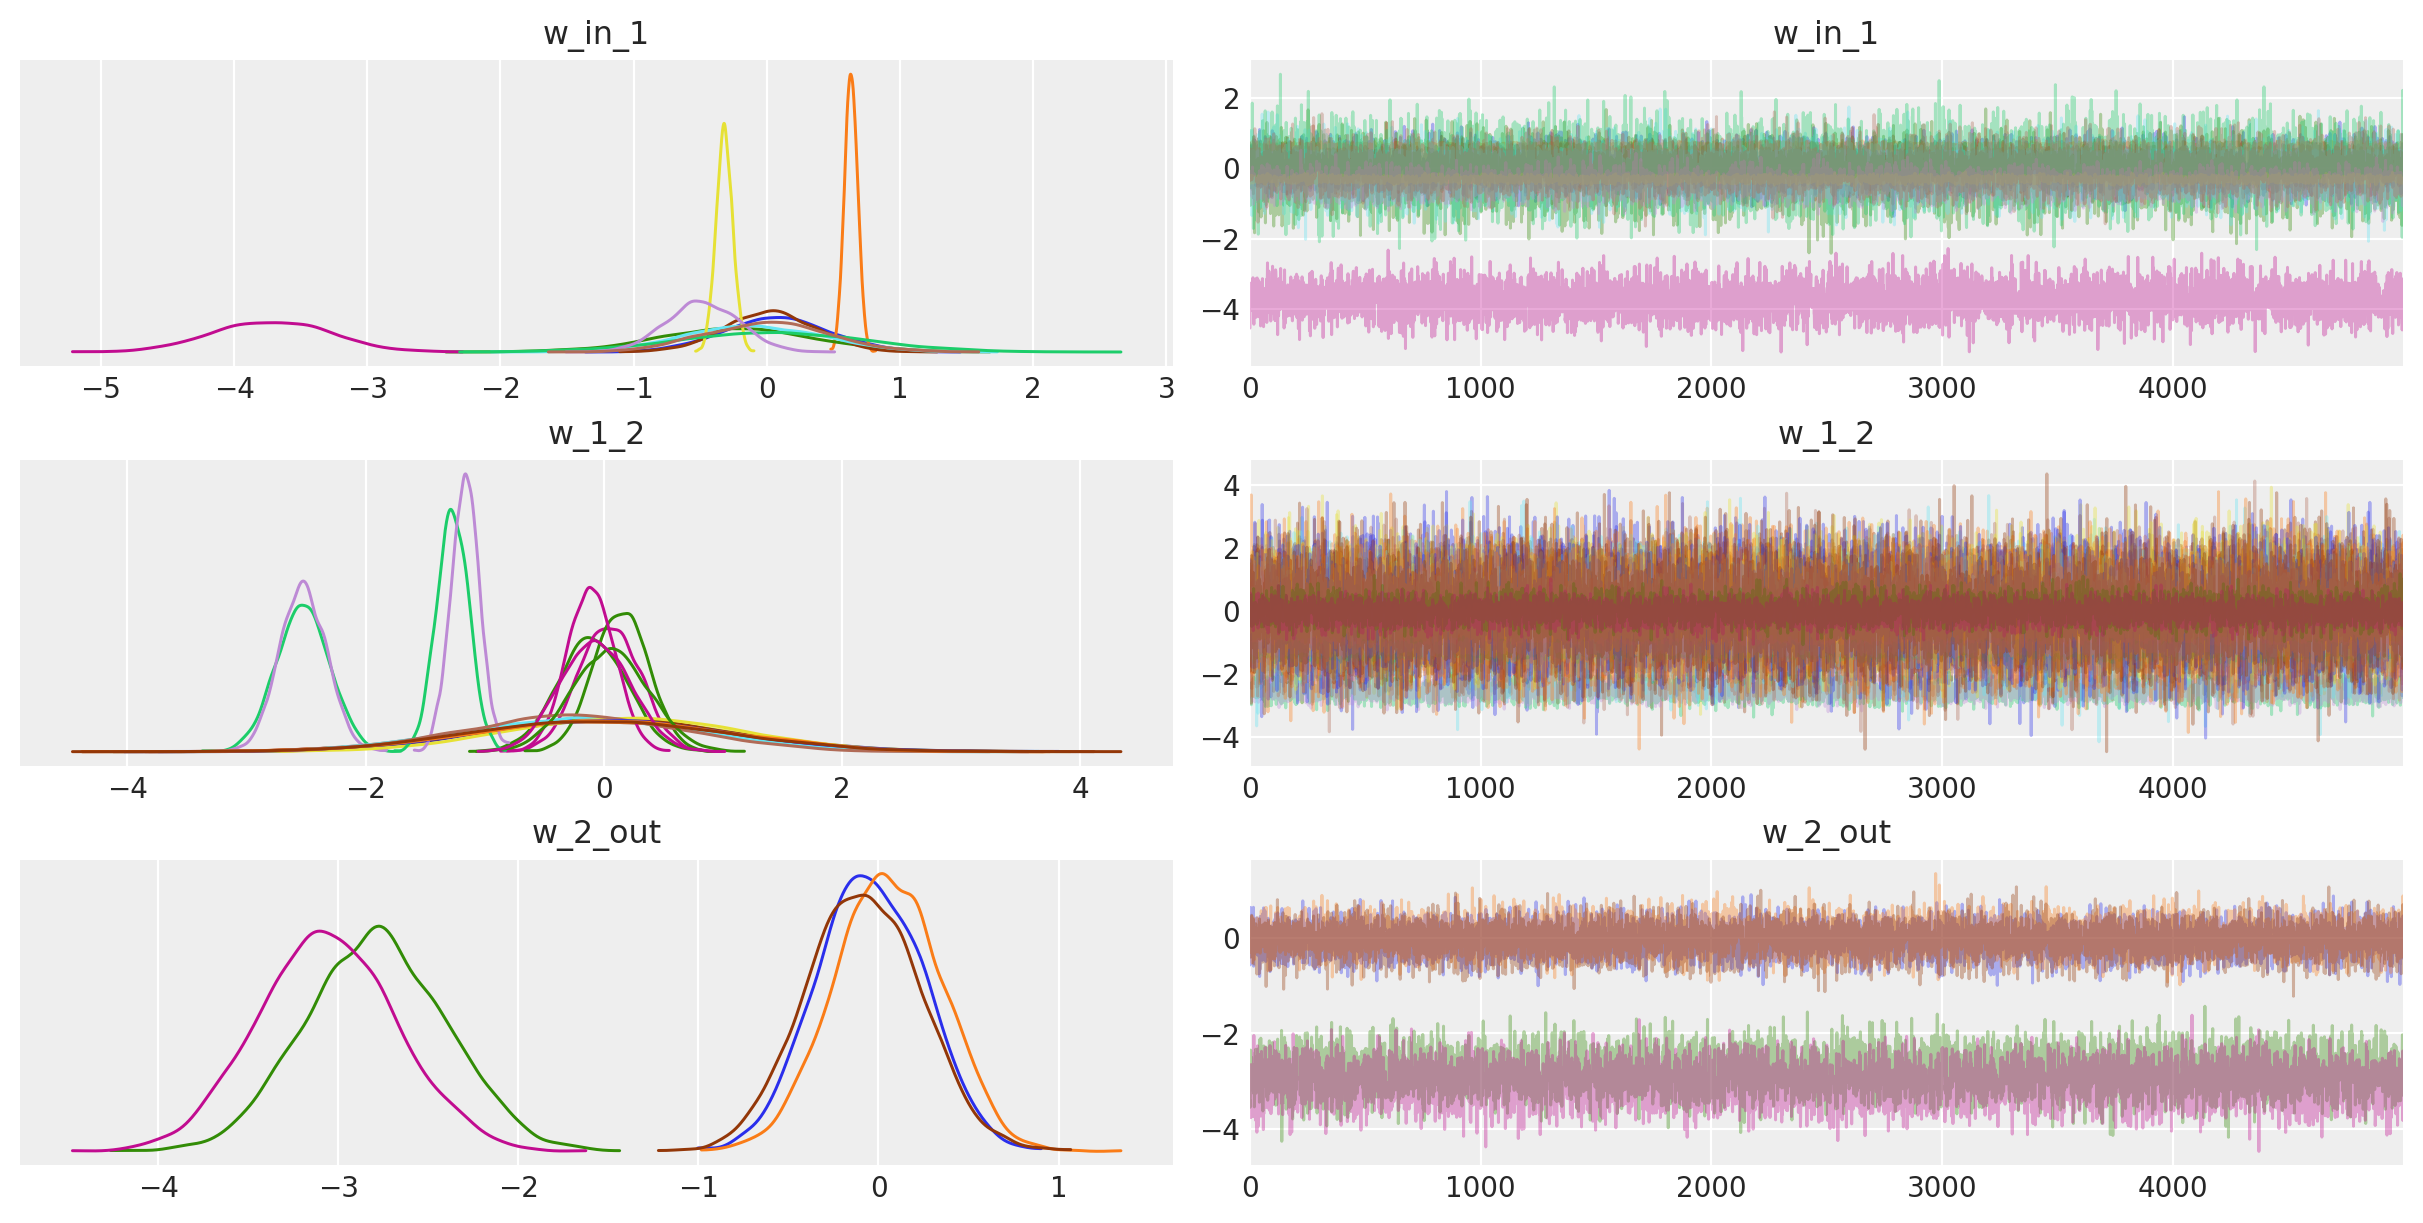

In [39]:
az.plot_trace(trace);

## Summary

Hopefully this blog post demonstrated a very powerful new inference algorithm available in PyMC3: {class}`~pymc3.variational.inference.ADVI`. I also think bridging the gap between Probabilistic Programming and Deep Learning can open up many new avenues for innovation in this space, as discussed above. Specifically, a hierarchical neural network sounds pretty bad-ass. These are really exciting times.

## Next steps

[`Theano`](https://github.com/Theano/Theano), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. Ideally, we wouldn't have to build the models by hand as I did above, but use the convenient syntax of `Lasagne` to construct the architecture, define our priors, and run ADVI. 

You can also run this example on the GPU by setting `device = gpu` and `floatX = float32` in your `.theanorc`.

You might also argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets.

I also presented some of this work at PyData London, view the video below:
<iframe width="560" height="315" src="https://www.youtube.com/embed/LlzVlqVzeD8" frameborder="0" allowfullscreen></iframe>

Finally, you can download this NB [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network.ipynb). Leave a comment below, and [follow me on twitter](https://twitter.com/twiecki).

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on ADVI in PyMC3, including the mini-batch implementation as well as the sampling from the variational posterior. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.

(c) 2017 by Thomas Wiecki, updated by Maxim Kochurov

Original [blog post](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Wed Oct 20 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

xarray: 0.17.0

numpy     : 1.19.5
arviz     : 0.11.4
seaborn   : 0.11.1
sklearn   : 0.0
matplotlib: 3.3.4
pymc3     : 3.11.2
theano    : 1.1.2

Watermark: 2.2.0

